# 🤗 Welcome to AdalFlow!
## The library to build & auto-optimize any LLM task pipelines

Thanks for trying us out, we're here to provide you with the best LLM application development experience you can dream of 😊 any questions or concerns you may have, [come talk to us on discord,](https://discord.gg/ezzszrRZvT) we're always here to help! ⭐ <i>Star us on <a href="https://github.com/SylphAI-Inc/AdalFlow">Github</a> </i> ⭐


# Quick Links

Github repo: https://github.com/SylphAI-Inc/AdalFlow

Full Tutorials: https://adalflow.sylph.ai/index.html#.

Deep dive on each API: check out the [developer notes](https://adalflow.sylph.ai/tutorials/index.html).

Common use cases along with the auto-optimization:  check out [Use cases](https://adalflow.sylph.ai/use_cases/index.html).

# Author

This notebook was created by [Li Yin]().

# Outline

This is a quick introduction of what AdalFlow is capable of. We will cover:

* Build a standard RAG.
* Evaluate the RAG performance with HotpotQA dataset using deepseek and gpt model series.
* Auto-optimize the RAG with the HotpotQA dataset.



# Installation

1. Use `pip` to install the `adalflow` Python package. We will need `openai` and `together` from the extra packages.

  ```bash
  pip install adalflow[openai,together]
  ```
2. Setup  `openai` and `groq` API key in the environment variables

In [1]:
from IPython.display import clear_output

!pip install -U adalflow[openai,together]

clear_output()

## Set Environment Variables

Run the following code and pass your api key.

Note: for normal `.py` projects, follow our [official installation guide](https://lightrag.sylph.ai/get_started/installation.html).

*Go to [OpenAI](https://platform.openai.com/docs/introduction) and [Together](https://www.together.ai/) to get API keys if you don't already have.*

In [1]:
import os

from getpass import getpass

# Prompt user to enter their API keys securely
# openai_api_key = getpass("Please enter your OpenAI API key: ")
# groq_api_key = getpass("Please enter your GROQ API key: ")

OPENAI_API_KEY = "sk-proj-gX9mcLCGI7XGyqViWImuT3BlbkFJHqb4CoTTxqKTc3gjvV6S"
TOGETHER_API_KEY = "870fb7f473b8c13b5c6d40942e13cded205fbdb537aed6108d2e420db429e048"


# Set environment variables
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["GROQ_API_KEY"] = TOGETHER_API_KEY

print("API keys have been set.")

API keys have been set.


# 😇 Build the RAG

We will use DsPy's retriever in this demonstration to retrieve relevant documents from wikipedia. We will wrap it into AdalFlow's retriever api and use AdalFlow's generator to generate the answer.

In [2]:
!pip install dspy
clear_output()


[notice] A new release of pip is available: 24.1.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


NameError: name 'clear_output' is not defined

In [2]:
# wrap the retriever

import adalflow as adal
from adalflow.core.types import RetrieverOutput
import dspy
from typing import Optional

colbertv2_wiki17_abstracts = dspy.ColBERTv2(
    url="http://20.102.90.50:2017/wiki17_abstracts"
)

dspy.settings.configure(rm=colbertv2_wiki17_abstracts)


class DspyRetriever(adal.Retriever):
    def __init__(self, top_k: int = 3):
        super().__init__()
        self.top_k = top_k
        self.dspy_retriever = dspy.Retrieve(k=top_k)

    def call(
        self, input: str, top_k: Optional[int] = None, id: str = None
    ) -> RetrieverOutput:

        k = top_k or self.top_k

        if not input:
            raise ValueError(f"Input cannot be empty, top_k: {k}")

        output = self.dspy_retriever(query=input, k=k)
        # print(f"dsy_retriever output: {output}")
        documents = output.passages

        return RetrieverOutput(
            query=input,
            documents=documents,
            doc_indices=[],
        )

/Users/liyin/Documents/test/LightRAG/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [3]:
from dataclasses import dataclass, field
from typing import Union


# output data class
@dataclass
class AnswerData(adal.DataClass):
    reasoning: str = field(
        metadata={"desc": "The reasoning to produce the answer"},
    )
    answer: str = field(
        metadata={"desc": "The answer you produced"},
    )

    __output_fields__ = ["reasoning", "answer"]


# prompt
task_desc_str = r"""Answer questions with short factoid answers.

You will receive context(contain relevant facts).
Think step by step."""

answer_template = """<START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
"""


class VanillaRAG(adal.Component):
    def __init__(self, passages_per_hop=3, model_client=None, model_kwargs=None):
        super().__init__()

        self.passages_per_hop = passages_per_hop

        self.retriever = DspyRetriever(top_k=passages_per_hop)
        self.llm_parser = adal.DataClassParser(
            data_class=AnswerData, return_data_class=True, format_type="json"
        )
        self.llm = adal.Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            prompt_kwargs={
                "task_desc_str": adal.Parameter(
                    data=task_desc_str,
                    role_desc="""Task description for the language model,\
                    used with the following template: \
                    {{task_desc_str}} \
                    {{output_format_str}}\
                    <START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>""",
                    param_type=adal.ParameterType.PROMPT,
                    requires_opt=True,
                    instruction_to_backward_engine="You need find the best way(where does the right answer come from the context) to extract the RIGHT answer from the context.",
                    instruction_to_optimizer="You need find the best way(where does the right answer come from the context) to extract the RIGHT answer from the context.",
                ),
                "output_format_str": self.llm_parser.get_output_format_str(),
            },
            template=answer_template,
            output_processors=self.llm_parser,
            use_cache=True,
        )

    def bicall(
        self, question: str, id: str = None
    ) -> Union[adal.GeneratorOutput, adal.Parameter]:
        """This function is used to call the model for both training and eval mode."""
        retriever_out = self.retriever(input=question)
        retrieved_context = None
        if isinstance(retriever_out, adal.Parameter):
            successor_map_fn = lambda x: (  # noqa E731
                "\n\n".join(x.data.documents)
                if x.data and x.data and x.data.documents
                else ""
            )
            retriever_out.add_successor_map_fn(
                successor=self.llm, map_fn=successor_map_fn
            )
        else:
            successor_map_fn = lambda x: (  # noqa E731
                "\n\n".join(x.documents) if x and x.documents else ""
            )
            retrieved_context = successor_map_fn(retriever_out)
        prompt_kwargs = {
            "context": retrieved_context,
            "question": question,
        }
        output = self.llm(prompt_kwargs=prompt_kwargs, id=id)
        return output

In [4]:
# all models options
from adalflow.components.model_client.openai_client import OpenAIClient
from adalflow.components.model_client.together_client import TogetherClient


gpt_3_model = {
    "model_client": OpenAIClient(input_type="text"),
    "model_kwargs": {
        "model": "gpt-3.5-turbo-0125",
        "max_tokens": 2000,
        "temperature": 0.0,
        "top_p": 0.99,
        "frequency_penalty": 0,
        "presence_penalty": 0,
        "stop": None,
    },
}

gpt_o1_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "o1",
        "temperature": 1,
        # "top_p": 0.99,
    },
}

gpt_o3_mini_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "o3-mini",
        "temperature": 1,
        # "top_p": 0.99,
    },
}

gpt_4o_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "gpt-4o",
        "temperature": 1,
        "top_p": 0.99,
    },
}

deepseek_r1_model = {
    "model_client": TogetherClient(),
    "model_kwargs": {
        "model": "deepseek-ai/DeepSeek-R1",
        "temperature": 1,
        "top_p": 0.99,
    },
}

deepseek_r1_distilled_model = {
    "model_client": TogetherClient(),
    "model_kwargs": {
        "model": "deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
        "temperature": 1,
        "top_p": 0.99,
    },
}

In [5]:
rag = VanillaRAG(**gpt_o1_model)

query = "Who is Shakespear?"

output = rag.bicall(query)
print(output)
output.data

GeneratorOutput(id=None, data=AnswerData(reasoning='The context lists three different individuals named Shakespear: Ronald Shakespear (Argentine graphic designer), William Henry Irvine Shakespear (British civil servant and explorer), and Wilma Shakespear (Australian netball player, coach, and sports administrator).', answer='They are multiple individuals: Ronald Shakespear, William Henry Irvine Shakespear, and Wilma Shakespear.'), error=None, usage=CompletionUsage(completion_tokens=615, prompt_tokens=346, total_tokens=961), raw_response='```\n{\n    "reasoning": "The context lists three different individuals named Shakespear: Ronald Shakespear (Argentine graphic designer), William Henry Irvine Shakespear (British civil servant and explorer), and Wilma Shakespear (Australian netball player, coach, and sports administrator).",\n    "answer": "They are multiple individuals: Ronald Shakespear, William Henry Irvine Shakespear, and Wilma Shakespear."\n}\n```', metadata=None)


AnswerData(reasoning='The context lists three different individuals named Shakespear: Ronald Shakespear (Argentine graphic designer), William Henry Irvine Shakespear (British civil servant and explorer), and Wilma Shakespear (Australian netball player, coach, and sports administrator).', answer='They are multiple individuals: Ronald Shakespear, William Henry Irvine Shakespear, and Wilma Shakespear.')

In [6]:
# check the dataset
from adalflow.datasets.hotpot_qa import HotPotQA


def load_datasets():

    trainset = HotPotQA(split="train", size=100)  # 20
    valset = HotPotQA(split="val", size=100)  # 50
    testset = HotPotQA(split="test", size=200)  # to keep the same as the dspy #50
    print(f"trainset, valset: {len(trainset)}, {len(valset)}, example: {trainset[0]}")
    return trainset, valset, testset

In [7]:
trainset, valset, testset = load_datasets()
trainset[0]

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pacific convergence zone as a small tropical depression on November 13, to the northeast of the Solomon Islands.', ' Over the next few days the system gradually developed further within an area of light winds in the upper troposphere, before it was named Tia early on November 16.', ' Later that

In [8]:
# test on one using gpt o1 and deepseek r1

rag_o1 = VanillaRAG(**gpt_o1_model)
rag_deepseek_r1 = VanillaRAG(**deepseek_r1_model)

query = trainset[0].question
output_o1 = rag_o1.bicall(query)
output_deepseek_r1 = rag_deepseek_r1.bicall(query)

print(f"query: {query}")
print(f"output_o1: {output_o1.data}")
print(f"output_deepseek_r1: {output_deepseek_r1.data}")
print(f"answer: {trainset[0].answer}")

query: Which host of Whodunnit died on November 16, 2009?
output_o1: AnswerData(reasoning='Edward Woodward died on 16 November 2009.', answer='Edward Woodward')
output_deepseek_r1: AnswerData(reasoning="The question asks which host of 'Whodunnit?' died on November 16, 2009. From the context, the UK series (1973–1978) had hosts Edward Woodward (1973) and Jon Pertwee (1974–1978). The US version (1979) was hosted by Ed McMahon. Jon Pertwee died in 1996, Ed McMahon in 2009 (June 23), and Edward Woodward died on November 16, 2009, making him the correct answer.", answer='Edward Woodward')
answer: Edward Woodward


## AdalComponent to manage training and evaluation

In [9]:
from adalflow.eval.answer_match_acc import AnswerMatchAcc
from adalflow.datasets.types import HotPotQAData

from typing import Dict, Tuple, Callable, Any


class HotPotQAAdal(adal.AdalComponent):
    def __init__(
        self,
        backward_engine_model_config: Dict | None = None,
        teacher_model_config: Dict | None = None,
        text_optimizer_model_config: Dict | None = None,
        task: adal.Component | None = None,  # initialized task
    ):

        eval_fn = AnswerMatchAcc(type="exact_match").compute_single_item
        loss_eval_fn = AnswerMatchAcc(type="f1_score").compute_single_item

        loss_fn = adal.EvalFnToTextLoss(
            eval_fn=loss_eval_fn,
            eval_fn_desc="exact_match: 1 if str(y_gt) == str(y) else 0",
        )
        super().__init__(
            task=task,
            eval_fn=eval_fn,
            loss_eval_fn=loss_eval_fn,
            loss_fn=loss_fn,
            backward_engine_model_config=backward_engine_model_config,
            teacher_model_config=teacher_model_config,
            text_optimizer_model_config=text_optimizer_model_config,
        )

    def prepare_task(self, sample: HotPotQAData) -> Tuple[Callable[..., Any], Dict]:
        if self.task.training:
            return self.task.forward, {"question": sample.question, "id": sample.id}
        else:
            return self.task.call, {"question": sample.question, "id": sample.id}

    def prepare_eval(self, sample: HotPotQAData, y_pred: adal.GeneratorOutput) -> float:
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer  # .lower()
        # printc(f"y_label: {y_label}, y_gt: {sample.answer}")
        return self.eval_fn, {"y": y_label, "y_gt": sample.answer}

    def prepare_loss_eval(self, sample: Any, y_pred: Any, *args, **kwargs) -> float:
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer
        return self.loss_eval_fn, {"y": y_label, "y_gt": sample.answer}

    def prepare_loss(self, sample: HotPotQAData, pred: adal.Parameter):
        y_gt = adal.Parameter(
            name="y_gt",
            data=sample.answer,
            eval_input=sample.answer,
            requires_opt=False,
        )

        pred.eval_input = (
            pred.data.data.answer
            if pred.data and pred.data.data and pred.data.data.answer
            else ""
        )
        # TODO: understand better of the goal of gt and input
        return self.loss_fn, {
            "kwargs": {"y": pred, "y_gt": y_gt},
            "input": {"question": sample.question},
            "gt": sample.answer,
            "id": sample.id,
        }

### Evaluation only

In [10]:
def train_diagnose(model_client, model_kwargs):

    _, _, testset = load_datasets()

    task = VanillaRAG(
        model_client=model_client,
        model_kwargs=model_kwargs,
        passages_per_hop=3,
    )

    adal_component = HotPotQAAdal(
        task=task,
    )
    trainer = adal.Trainer(adaltask=adal_component)
    trainer.diagnose(dataset=testset, split="train")

In [12]:
train_diagnose(**gpt_o1_model)  # 2m11s without cache #57% on trainm 49% on test

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json


Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl


split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pacific convergence zone as a small tropical depression on November 13, to the northeast 

Loading Data: 100%|██████████| 200/200 [00:00<00:00, 54039.86it/s]
Predicting: step(0): 0.49 across 200 samples, Max potential: 0.49: 100%|██████████| 200/200 [00:00<00:00, 495.51it/s]   
Error loading jsonl file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl: line contains invalid json: unexpected content after document: line 1 column 8686 (char 8685) (line 114)


Log file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.49
✔ Log paths:
  - Log 1: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

✔ Diagnose report completed successfully!




In [57]:
train_diagnose(**deepseek_r1_model)  # 34m 226s without cache #46%

# r1 have some structure format issue.and it seems together hosting is slow

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 42517.02it/s]Error at parsing output: Expected data of type dict for <class '__main__.AnswerData'>, but got list

Error processing the output processors: Error: Expected data of type dict for <class '__main__.AnswerData'>, but got list
Predicting: step(0): 0.4 across 5 samples, Max potential: 0.97:   4%|▍         | 4/100 [00:00<00:00, 141.93it/s]   Error at parsing output: Expected data of type dict for <class '__main__.AnswerData'>, but got list
Predicting: step(0): 0.3333 across 6 samples, Max potential: 0.96:   5%|▌         | 5/100 [00:00<00:00, 136.23it/s]Error processing the output processors: Error: Expected data of type dict for <class '__main__.AnswerData'>, but got list
Predicting: step(0): 0.2222 across 9 samples, Max potential: 0.93:   8%|▊         | 8/100 [00:00<00:00, 127.92it/s]Error at parsing 

Log file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.46
✔ Log paths:
  - Log 1: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

✔ Diagnose report completed successfully!




In [13]:
train_diagnose(**deepseek_r1_distilled_model)  # 41% 2m19.1s

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

Loading Data: 100%|██████████| 200/200 [00:00<00:00, 84400.93it/s]
Predicting: step(0): 0.1818 across 11 samples, Max potential: 0.955:   5%|▌         | 10/200 [00:17<07:19,  2.31s/it]Error at parsing output: Error: No JSON object or array found in the text: <think>
Okay, so I need to figure out which comic book was also written by the writer of Crossed. Let's start by looking at the context provided. 

First, there are three different entries here: Crossed (comics), Crossed (novel), and Star Crossed (comics). 

The question is about the comic book written by the same writer as Crossed. So I'm focusing on Crossed (comics), which is written by Garth Ennis, and then later by David Lapham for some volumes. 

Now, looking at the other entries, Star Crossed is a comic book mini-series written by Matt Howarth. Crossed (novel) is written by Allyson Braithwaite Condie.

Log file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.41
✔ Log paths:
  - Log 1: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

✔ Diagnose report completed successfully!




In [59]:
train_diagnose(**gpt_o3_mini_model)  # 56%, 1m58s

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 34388.00it/s]
Predicting: step(0): 0.56 across 100 samples, Max potential: 0.56: 100%|██████████| 100/100 [00:00<00:00, 183.70it/s]
Error loading jsonl file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl: line contains invalid json: unexpected content after document: line 1 column 8686 (char 8685) (line 114)


Log file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.56
✔ Log paths:
  - Log 1: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

✔ Diagnose report completed successfully!




In [14]:
train_diagnose(**gpt_3_model)  # 42% 25s

split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/train.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/val.json
split_csv_path: /Users/liyin/.adalflow/cache_datasets/hotpot_qa_dev_titles/test.json
trainset, valset: 100, 100, example: HotPotQAData(id='5a7cc25d5542990527d55520', question='Which host of Whodunnit died on November 16, 2009?', answer='Edward Woodward', gold_titles={'Edward Woodward', 'Whodunnit? (UK TV series)'}, context={'title': ['Cyclone Tia', 'Harry Taylor (ice hockey)', 'Edward Woodward', 'Cheikh El Avia Ould Mohamed Khouna', 'Tornado outbreak of November 16–18, 2015', 'Whodunnit? (UK TV series)', 'First Cabinet of Donald Tusk', 'Maranhão gubernatorial election, 1994', 'Clark Van Galder', 'James Fraser Mustard'], 'sentences': [['Severe Tropical Cyclone Tia was the first of six tropical cyclones to affect Vanuatu, during the 1991–92 South Pacific cyclone season.', ' The system was first noted within the South Pac

Generator llm is already registered with jsonl file at /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

Loading Data: 100%|██████████| 200/200 [00:00<00:00, 92681.56it/s]
Predicting: step(0): 0.395 across 200 samples, Max potential: 0.395: 100%|██████████| 200/200 [00:00<00:00, 432.60it/s] 
Error loading jsonl file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl: line contains invalid json: unexpected content after document: line 1 column 8686 (char 8685) (line 114)


Log file /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.40
✔ Log paths:
  - Log 1: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/diagnose_train/llm_call.jsonl

✔ Diagnose report completed successfully!




Here is the current performance on the tested modeles:

**Train dataset**

| Model | EM | Running Time | Notes |
| --- | --- | --- | --- |
| o1  | 57 | 2m12s |  |
| o3mini  | 56 | 1m58s |  |
| gpt3.5 | 42 | 25s | |
| r1  | 46 | 34m | structure data format errors, the <br> running time might because of the <br> deployment rather than the model itself |
| r1 distilled  | 41 | 2m19s | structure data format errors |

**Test dataset**

| Model | EM | Running Time | Notes |
| --- | --- | --- | --- |
| o1  | 49 | N/A |  |
| gpt3.5 | 40 |  | |
| r1 distilled  | 41.5 |  | structure data format errors |

# Training.

First, we will try to use cheaper models to do the same task with lower cost.
Let's train gpt3.5 with o3-mini first as o3-mini is the cheapest among 4o, o1.

In [16]:
from adalflow.core.generator import BackwardPassSetup


def train(
    task_model_cliet,
    task_model_kwargs,
    optimizer_model_config,
    backward_engine_model_config,
    train_batch_size=4,  # larger batch size is not that effective, probably because of llm's lost in the middle
    raw_shots: int = 0,
    bootstrap_shots: int = 4,
    max_steps=1,
    num_workers=4,
    strategy="constrained",
    optimization_order="sequential",
    debug=False,
    resume_from_ckpt=None,
    exclude_input_fields_from_bootstrap_demos=True,
    seed=None,
    max_proposals_per_step: int = 5,
    disable_backward_gradients: bool = False,
    disable_backward: bool = False,
):
    task = VanillaRAG(
        model_client=task_model_cliet,
        model_kwargs=task_model_kwargs,
        passages_per_hop=3,
    )

    adal_component = HotPotQAAdal(
        task=task,
        text_optimizer_model_config=optimizer_model_config,
        backward_engine_model_config=backward_engine_model_config,
    )

    trainer = adal.Trainer(
        train_batch_size=train_batch_size,
        adaltask=adal_component,
        strategy=strategy,
        max_steps=max_steps,
        num_workers=num_workers,
        raw_shots=raw_shots,
        bootstrap_shots=bootstrap_shots,
        debug=debug,
        weighted_sampling=False,
        optimization_order=optimization_order,
        exclude_input_fields_from_bootstrap_demos=exclude_input_fields_from_bootstrap_demos,
        max_proposals_per_step=max_proposals_per_step,
        text_optimizers_config_kwargs={"max_past_history": 5},
        disable_backward_gradients=disable_backward_gradients,
        disable_backward=disable_backward,
    )
    trainer.set_random_seed(seed)
    print(trainer)

    train_dataset, val_dataset, test_dataset = load_datasets()
    ckpt, _ = trainer.fit(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        resume_from_ckpt=resume_from_ckpt,
    )
    return ckpt

In [17]:
train(
    task_model_cliet=gpt_3_model["model_client"],
    task_model_kwargs=gpt_3_model["model_kwargs"],
    optimizer_model_config=gpt_o3_mini_model,
    backward_engine_model_config=gpt_o3_mini_model,
    max_steps=12,
)

Trainer(
  (adaltask): HotPotQAAdal(
    eval_fn: compute_single_item, backward_engine: None, backward_engine_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'o3-mini', 'temperature': 1}}, teacher_model_config: None, text_optimizer_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'o3-mini', 'temperature': 1}}
    (task): VanillaRAG(
      (retriever): DspyRetriever()
      (llm_parser): DataClassParser(
        data_class=AnswerData, format_type=json,            return_data_class=True, input_fields=[],            output_fields=['reasoning', 'answer']
        (_output_processor): JsonParser()
        (output_format_prompt): template: Your output should be formatted as a standard JSON instance with the following schema:
        ```
        {{schema}}
        ```
        -Make sure to always enclose the JSON output in triple backticks (```). Please do not add anything other than valid JSON output!
        -Use double quotes for the keys and


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 57908.38it/s]
Predicting: step(0): 0.38 across 100 samples, Max potential: 0.38: 100%|██████████| 100/100 [00:00<00:00, 331.56it/s]

Loading Data: 100%|██████████| 200/200 [00:00<00:00, 97225.41it/s]
Predicting: step(0): 0.395 across 200 samples, Max potential: 0.395: 100%|██████████| 200/200 [00:00<00:00, 455.90it/s] 


Initial validation score: 0.38
Initial test score: 0.395
2025-02-04 16:28:17 - [trainer.py:2336:_fit_text_grad_constraint] - Fitting using Textual Gradient Descent with constraints
_fit_text_grad_constraint save to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0


Training Step: 1:   0%|          | 0/25 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1475.96it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': 'Tom Watkins played college football for a team that plays their home games at what stadium?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'In which year the The National League of Professional Baseball Clubs was found with which William F. Klusman was played?'}, model_kwargs: {}
unwrapped_prompt_kwargs: {'context': None, 'question': 'The Simpson\'s episode "Das Bus" is a parody of a novel by what author?'}, model_kwargs: {}
unwrapped_prompt_kwargs: {'context': None, 'question': 'What city was Joseph Druces victim working in?'}, model_kwargs: {}

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>






Training:   0%|          | 0/4 [00:00<?, ?it/s]

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


2025-02-04 16:28:18 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:28:18 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:28:18 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:28:18 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 5006.63it/s]


Moving batch eval: EvaluationResult(avg_score=0.725, per_item_scores=[1.0, 0.4, 1.0, 0.5], additional_info=None)
2025-02-04 16:28:18 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.725
Moving batch correct size: 2
Moving batch error size: 2
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.725
2025-02-04 16:28:18 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.725,0.725
Subset loss backward...
2025-02-04 16:28:18 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:28:18 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:28:21 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: Boston, gt: Boston
2025-02-04 16:28:21 - [text_loss_with_eval_fn.py:386:backward] - EvalFnToTextLoss: y_gt set_s



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:28:41 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:28:41 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:28:45 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 924.42it/s]
Predicting: step(1): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]  


2025-02-04 16:28:46 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.725





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 34940.89it/s]
Predicting: step(1): 0.3737 across 99 samples, Max potential: 0.38:  99%|█████████▉| 99/100 [00:26<00:00,  3.69it/s]


Optimizer revert: 0.37 <= 0.38




Proposing:  20%|██        | 1/5 [00:32<02:08, 32.18s/it]

Proposal: 2
2025-02-04 16:29:13 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:29:13 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:29:17 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1968.69it/s]
Predicting: step(1): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]  


2025-02-04 16:29:18 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.725





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 41036.14it/s]
Predicting: step(1): 0.4 across 100 samples, Max potential: 0.4: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]  


Optimizer step: 0.4 > 0.38


Proposing:  20%|██        | 1/5 [01:02<04:11, 62.82s/it]


Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 2:   4%|▍         | 1/25 [01:26<34:39, 86.66s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 272.16it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': 'The 2010 Mnet Asian Music Awards were held at the casino owned by what company?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Top 5 Restaurants is a television series presented in part by which Food Network personality?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': "Who is the squash player who played in the Women's Allam British Open 2014 and has been in the top 10 for 151 months?"}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'When was the national park Mount Le Conte is located in chartered by Congress?'}, model_kwargs: {}





prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_d

Training:   0%|          | 0/4 [00:00<?, ?it/s]





2025-02-04 16:29:45 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:00<00:02,  1.09it/s]

2025-02-04 16:29:45 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:29:45 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:29:45 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2227.16it/s]


Moving batch eval: EvaluationResult(avg_score=0.4375, per_item_scores=[0, 0.75, 0, 1.0], additional_info=None)
2025-02-04 16:29:45 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.4375
Moving batch correct size: 2
Moving batch error size: 2
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.4375
2025-02-04 16:29:45 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.4375,0.4375
Subset loss backward...
2025-02-04 16:29:45 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:29:45 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:29:49 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: Las Vegas Sands Corporation, gt: American Las Vegas Sands
2025-02-04 16:29:49 - [text_loss_with_eval_fn.py:386



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:30:08 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:30:08 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:30:14 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 389.48it/s]
Predicting: step(2): 0.625 across 4 samples, Max potential: 0.625: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


2025-02-04 16:30:15 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.625 > 0.4375





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 9310.12it/s]
Predicting: step(2): 0.41 across 100 samples, Max potential: 0.41: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


Optimizer step: 0.41 > 0.4


Proposing:   0%|          | 0/5 [00:34<?, ?it/s]


Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 3:   8%|▊         | 2/25 [02:24<26:46, 69.87s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1229.19it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': 'Which country‘s show is the series ITV show that Nadia Forde participated present '}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Sahara Hotnights and Hurricane No. 1. are both what?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Which poet is older, Robert Frost or Paul Scott?'}, model_kwargs: {}

unwrapped_prompt_kwargs: {'context': None, 'question': 'Who defeated Sander Levin in the Michigan gubernatorial election, 1970? '}, model_kwargs: {}


prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


Training:   0%|          | 0/4 [00:00<?, ?it/s]

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


2025-02-04 16:30:43 - [generator.py:612:forward] - disable_backward_engine config: False2025-02-04 16:30:43 - [generato

Training:  25%|██▌       | 1/4 [00:01<00:03,  1.02s/it]

2025-02-04 16:30:43 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2491.05it/s]


Moving batch eval: EvaluationResult(avg_score=0.2, per_item_scores=[0.4, 0, 0, 0.4], additional_info=None)
2025-02-04 16:30:43 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.2
Moving batch correct size: 0
Moving batch error size: 4
Subset Error size: 2
Subset Correct size: 0
Subset score: 0.0
2025-02-04 16:30:43 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.0,0.0
Subset loss backward...
2025-02-04 16:30:43 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:30:43 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:30:46 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: British, gt: UK
2025-02-04 16:30:46 - [text_loss_with_eval_fn.py:386:backward] - EvalFnToTextLoss: Generator_outputy_pred_2 se



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:30:56 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:30:56 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:31:00 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 631.77it/s]
Predicting: step(3): 0.9 across 2 samples, Max potential: 0.9: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


2025-02-04 16:31:02 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.9 > 0.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 32017.59it/s]
Predicting: step(3): 0.42 across 100 samples, Max potential: 0.42: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


Optimizer step: 0.42 > 0.41


Proposing:   0%|          | 0/5 [00:30<?, ?it/s]


Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 4:  12%|█▏        | 3/25 [03:08<21:17, 58.06s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 307.56it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': 'What occupation do both Rob Pinkston and Frankie Muniz both share? '}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What did Nirvana do differently with "In Utero" that caused a documentary to be made about recording the album?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What company is associated with both White Wilderness and The Mighty Ducks?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Which midsize car  of 1973 to 2005 used a shared platform with Pontiac 6000?'}, model_kwargs: {}





prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demo

Training:   0%|          | 0/4 [00:00<?, ?it/s]





2025-02-04 16:31:27 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:00<00:01,  1.71it/s]

2025-02-04 16:31:27 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:31:27 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:31:27 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13695.69it/s]


Moving batch eval: EvaluationResult(avg_score=0.3111111111111111, per_item_scores=[0, 0.4444444444444445, 0.8, 0], additional_info=None)
2025-02-04 16:31:27 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.3111111111111111
Moving batch correct size: 1
Moving batch error size: 3
Subset Error size: 2
Subset Correct size: 1
Subset score: 0.4148148148148148
2025-02-04 16:31:27 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.4148148148148148,0.4148148148148148
Subset loss backward...
2025-02-04 16:31:27 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:31:27 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:31:29 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: Worked with producer Steve Albini, g



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:31:43 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:31:43 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:31:49 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1985.31it/s]
Predicting: step(4): 0.375 across 3 samples, Max potential: 0.375: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]  


2025-02-04 16:31:51 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.375 <= 0.4148148148148148




Proposing:  20%|██        | 1/5 [00:07<00:30,  7.62s/it]

Proposal: 2
2025-02-04 16:31:51 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:31:51 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:31:56 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1736.05it/s]
Predicting: step(4): 0.3678 across 3 samples, Max potential: 0.3678: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


2025-02-04 16:31:58 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.367816091954023 <= 0.4148148148148148




Proposing:  40%|████      | 2/5 [00:14<00:21,  7.25s/it]

Proposal: 3
2025-02-04 16:31:58 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:31:58 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:32:05 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 845.74it/s]
Predicting: step(4): 0.8963 across 3 samples, Max potential: 0.8963: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


2025-02-04 16:32:06 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.8962962962962964 > 0.4148148148148148





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5593.08it/s]
Predicting: step(4): 0.43 across 100 samples, Max potential: 0.43: 100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


Optimizer step: 0.43 > 0.42


Proposing:  40%|████      | 2/5 [00:43<01:05, 21.90s/it]


Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 5:  16%|█▌        | 4/25 [04:09<20:44, 59.24s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1111.66it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': ' What the locals consider for a suburb of a town which is in the Division of Mayo?'}, model_kwargs: {}

unwrapped_prompt_kwargs: {'context': None, 'question': 'Kansas City Bomber was produced by what American media company?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What was the occupation of Miss Lebanon from the last year Donald Trump owned the pageant?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Are Cynara and Piptanthus both flowering plants?'}, model_kwargs: {}



prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


Training:   0%|          | 0/4 [00:00<?, ?it/s]

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>




2025-02-04 16:32:28 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:32:28 - [generato

Training: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 3159.55it/s]


Moving batch eval: EvaluationResult(avg_score=0.0, per_item_scores=[0, 0, 0, 0], additional_info=None)
2025-02-04 16:32:30 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.0
Moving batch correct size: 0
Moving batch error size: 4
Subset Error size: 2
Subset Correct size: 0
Subset score: 0.0
2025-02-04 16:32:30 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.0,0.0
Subset loss backward...
2025-02-04 16:32:30 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:32:30 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:32:33 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: Yes, gt: no
2025-02-04 16:32:33 - [text_loss_with_eval_fn.py:386:backward] - EvalFnToTextLoss: Generator_outputy_pred_3 set_score:



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:32:41 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:32:41 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:32:47 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 1749.45it/s]
Predicting: step(5): 0.5 across 2 samples, Max potential: 0.5: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


2025-02-04 16:32:48 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.5 > 0.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 38126.57it/s]
Predicting: step(5): 0.4124 across 97 samples, Max potential: 0.43:  97%|█████████▋| 97/100 [00:19<00:00,  4.86it/s]


Optimizer revert: 0.40816326530612246 <= 0.43




Proposing:  20%|██        | 1/5 [00:26<01:46, 26.63s/it]

Proposal: 2
2025-02-04 16:33:08 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:33:08 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:33:13 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 1885.08it/s]
Predicting: step(5): 0.25 across 2 samples, Max potential: 0.25: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


2025-02-04 16:33:14 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.25 > 0.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 19607.80it/s]
Predicting: step(5): 0.45 across 100 samples, Max potential: 0.45: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Optimizer step: 0.45 > 0.43


Proposing:  20%|██        | 1/5 [00:56<03:45, 56.40s/it]


Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 6:  20%|██        | 5/25 [05:20<21:07, 63.39s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 691.22it/s]


unwrapped_prompt_kwargs: {'context': None, 'question': 'Are both Copella juice products and Tizer made purely from fresh fruits?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What year did Mark Wahlburg star in the American crime drama film directed by Martin Scorsese and written by William Monahan, a remake of the 2002 Hong Kong film "Infernal Affairs"?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Which of these Egyptians was a real person, Nefermaat or Bastet?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'The film "Puncture" stars an actor that plays what super hero in the Marvel Cinematic Universe?'}, model_kwargs: {}





Training:   0%|          | 0/4 [00:00<?, ?it/s]

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos

Training:  25%|██▌       | 1/4 [00:00<00:02,  1.10it/s]

2025-02-04 16:33:40 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 4061.30it/s]


Moving batch eval: EvaluationResult(avg_score=0.75, per_item_scores=[1.0, 1.0, 1.0, 0], additional_info=None)
2025-02-04 16:33:40 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.75
Moving batch correct size: 3
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6666666666666666
2025-02-04 16:33:40 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.6666666666666666,0.6666666666666666
Subset loss backward...
2025-02-04 16:33:40 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:33:40 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:33:43 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: Nefermaat, gt: Nefermaat
2025-02-04 16:33:43 - [text_loss_with_eval_fn.py:386



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:33:57 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:33:57 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:34:06 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 936.30it/s]
Predicting: step(6): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


2025-02-04 16:34:08 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666666 <= 0.6666666666666666




Proposing:  20%|██        | 1/5 [00:11<00:44, 11.07s/it]

Proposal: 2
2025-02-04 16:34:08 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:34:08 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:34:14 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1140.79it/s]
Predicting: step(6): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


2025-02-04 16:34:16 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666666 <= 0.6666666666666666




Proposing:  40%|████      | 2/5 [00:18<00:27,  9.18s/it]

Proposal: 3
2025-02-04 16:34:16 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:34:16 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:34:22 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1542.40it/s]
Predicting: step(6): 1.0 across 3 samples, Max potential: 1.0: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


2025-02-04 16:34:24 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 1.0 > 0.6666666666666666





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 55864.46it/s]
Predicting: step(6): 0.46 across 100 samples, Max potential: 0.46: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Optimizer step: 0.46 > 0.45


Proposing:  40%|████      | 2/5 [00:49<01:14, 24.95s/it]


Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 7:  24%|██▍       | 6/25 [06:29<20:39, 65.23s/it]

Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': 'Which host of Whodunnit died on November 16, 2009?'}, model_kwargs: {}

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 768.36it/s]


unwrapped_prompt_kwargs: {'context': None, 'question': 'Where is the institute formerly directed by food technologist Vishweshwaraiah Prakash located?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'The coach who led the 2016 University of Central Florida football team was previously the offensive coordinator for what other college?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Bo Knows Bo is the autobiography of the professional from which two sports?'}, model_kwargs: {}prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>






prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


Training:   0%|          | 0/4 [00:00<?, ?it/s]




2025-02-04 16:34:47 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:34:47 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:34:47 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:00<00:02,  1.40it/s]

2025-02-04 16:34:47 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 8991.01it/s]


Moving batch eval: EvaluationResult(avg_score=0.3142857142857143, per_item_scores=[0.8571428571428571, 0, 0, 0.4], additional_info=None)
2025-02-04 16:34:47 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.3142857142857143
Moving batch correct size: 1
Moving batch error size: 3
Subset Error size: 2
Subset Correct size: 1
Subset score: 0.41904761904761906
2025-02-04 16:34:47 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.41904761904761906,0.41904761904761906
Subset loss backward...
2025-02-04 16:34:47 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:34:47 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:34:50 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: Ronnie Corbett, gt: Edward Woodwa



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:35:05 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:35:05 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:35:10 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1423.89it/s]
Predicting: step(7): 0.8889 across 3 samples, Max potential: 0.8889: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


2025-02-04 16:35:11 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.8888888888888888 > 0.41904761904761906





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 14003.89it/s]
Predicting: step(7): 0.4255 across 94 samples, Max potential: 0.46:  94%|█████████▍| 94/100 [00:20<00:01,  4.53it/s]


Optimizer revert: 0.42105263157894735 <= 0.46




Proposing:  20%|██        | 1/5 [00:26<01:47, 26.92s/it]

Proposal: 2
2025-02-04 16:35:32 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:35:32 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:35:37 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 2039.37it/s]
Predicting: step(7): 0.8889 across 3 samples, Max potential: 0.8889: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


2025-02-04 16:35:38 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.8888888888888888 > 0.41904761904761906





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 28546.27it/s]
Predicting: step(7): 0.48 across 100 samples, Max potential: 0.48: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Optimizer step: 0.48 > 0.46


Proposing:  20%|██        | 1/5 [00:57<03:48, 57.11s/it]


Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 8:  28%|██▊       | 7/25 [07:45<20:35, 68.64s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 428.54it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': 'Are Jean-Julien Rojer and Květa Peschke both professional tennis players?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What is the popular martial arts technique associated with Wing Chun Kung Fu with the abbreviation JKD?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'These heads of powerful talking Olmec rulers were featured in what Nickelodeon show which aired from 1993 to 1995?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': "Shaker Paleja's film roles include an appearance in The Day the Earth Stood Still with a Canadian actor, director, producer, adn musician who was born in what year?"}, model_kwargs: {}




prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


Training:   0%|          | 0/4 [00:00<?, ?it/s]

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>




2025-02-04 16:36:03 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:36:03 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:00<00:02,  1.28it/s]

2025-02-04 16:36:03 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:36:03 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18957.31it/s]


Moving batch eval: EvaluationResult(avg_score=1.0, per_item_scores=[1.0, 1.0, 1.0, 1.0], additional_info=None)
2025-02-04 16:36:03 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 1.0
Moving batch correct size: 4
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 1.0
2025-02-04 16:36:03 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 1.0,1.0
Subset loss backward...
2025-02-04 16:36:03 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:36:03 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:36:07 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: Yes, gt: yes
2025-02-04 16:36:07 - [text_loss_with_eval_fn.py:386:backward] - EvalFnToTextLoss: Generator_outputy_pred_0 s



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:36:10 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:36:10 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:36:16 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 1221.76it/s]
Predicting: step(8): 0.0 across 2 samples, Max potential: 0.0: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


2025-02-04 16:36:18 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.0 <= 1.0




Proposing:  20%|██        | 1/5 [00:07<00:30,  7.70s/it]

Proposal: 2
2025-02-04 16:36:18 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:36:18 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:36:24 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 912.80it/s]
Predicting: step(8): 0.0 across 2 samples, Max potential: 0.0: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


2025-02-04 16:36:25 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.0 <= 1.0




Proposing:  40%|████      | 2/5 [00:14<00:22,  7.46s/it]

Proposal: 3
2025-02-04 16:36:25 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:36:25 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:36:30 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 923.35it/s]
Predicting: step(8): 0.0 across 2 samples, Max potential: 0.0: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


2025-02-04 16:36:31 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.0 <= 1.0




Proposing:  60%|██████    | 3/5 [00:21<00:14,  7.07s/it]

Proposal: 4
2025-02-04 16:36:31 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:36:31 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:36:38 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 1746.54it/s]
Predicting: step(8): 0.5 across 2 samples, Max potential: 0.5: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


2025-02-04 16:36:39 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5 <= 1.0




Proposing:  80%|████████  | 4/5 [00:28<00:07,  7.20s/it]

Proposal: 5
2025-02-04 16:36:39 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:36:39 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:36:48 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 63.31it/s]
Predicting: step(8): 0.0 across 2 samples, Max potential: 0.0: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


2025-02-04 16:36:49 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.0 <= 1.0




Proposing: 100%|██████████| 5/5 [00:39<00:00,  7.94s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 9:  32%|███▏      | 8/25 [08:32<17:32, 61.88s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 284.27it/s]


unwrapped_prompt_kwargs: {'context': None, 'question': 'Are Mary McCarthy and Chuck Palahniuk both American?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What do Angela Carter and Josephine Tey have in common?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Both John Davis and Blind Tom Wiggins are known for playing what musical instrument? '}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Are Dragon 32/64 and TK82C both headquartered in the same country?'}, model_kwargs: {}




Training:   0%|          | 0/4 [00:00<?, ?it/s]


prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demo

Training:  25%|██▌       | 1/4 [00:01<00:03,  1.09s/it]

2025-02-04 16:36:51 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 7504.91it/s]


Moving batch eval: EvaluationResult(avg_score=0.875, per_item_scores=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0], additional_info=None)
2025-02-04 16:36:51 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.875
Moving batch correct size: 7
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6666666666666666
2025-02-04 16:36:51 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.6666666666666666,0.6666666666666666
Subset loss backward...
2025-02-04 16:36:51 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:36:51 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:36:55 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: British authors, gt: writer
2025-02-04 16:36:55 - [text



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:37:07 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:37:07 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:37:12 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1289.36it/s]
Predicting: step(9): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


2025-02-04 16:37:13 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666666 <= 0.6666666666666666




Proposing:  20%|██        | 1/5 [00:05<00:23,  5.92s/it]

Proposal: 2
2025-02-04 16:37:13 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:37:13 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:37:18 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1614.64it/s]
Predicting: step(9): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


2025-02-04 16:37:19 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666666 <= 0.6666666666666666




Proposing:  40%|████      | 2/5 [00:11<00:17,  5.92s/it]

Proposal: 3
2025-02-04 16:37:19 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:37:19 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:37:26 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 2005.24it/s]
Predicting: step(9): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


2025-02-04 16:37:27 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666666 <= 0.6666666666666666




Proposing:  60%|██████    | 3/5 [00:19<00:13,  6.66s/it]

Proposal: 4
2025-02-04 16:37:27 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:37:27 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:37:32 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 306.15it/s]
Predicting: step(9): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


2025-02-04 16:37:34 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666666 <= 0.6666666666666666




Proposing:  80%|████████  | 4/5 [00:26<00:06,  6.75s/it]

Proposal: 5
2025-02-04 16:37:34 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:37:34 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:37:41 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 397.39it/s]
Predicting: step(9): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


2025-02-04 16:37:42 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666666 <= 0.6666666666666666




Proposing: 100%|██████████| 5/5 [00:34<00:00,  6.92s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 10:  36%|███▌      | 9/25 [09:24<15:42, 58.94s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1027.64it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': ' Kevin Daniels had a part in the 2004 American drama directed by whom?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Who direction the live action sequel to the Disney film based on Dodie Smith\'s 1956 novel "The Hundred and One Dalmatians"?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'How many seats can the stadium originally planned to host the 2017 NBA All-Star Game hold for NBA games?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'In which century was football introduced to this region represented by FC Espanya de Barcelona?'}, model_kwargs: {}





prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_d

Training:   0%|          | 0/4 [00:00<?, ?it/s]





2025-02-04 16:37:43 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:37:43 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:37:43 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:00<00:02,  1.40it/s]

2025-02-04 16:37:43 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Evaluating: 100%|██████████| 12/12 [00:00<00:00, 29995.02it/s]


Moving batch eval: EvaluationResult(avg_score=0.6666666666666666, per_item_scores=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0], additional_info=None)
2025-02-04 16:37:43 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.6666666666666666
Moving batch correct size: 8
Moving batch error size: 4
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.5
2025-02-04 16:37:43 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.5,0.5
Subset loss backward...
2025-02-04 16:37:43 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:37:43 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:37:45 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: British authors, gt: writer
2025-02-04 16:37:45 - [text_loss



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:38:01 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:38:01 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:38:07 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 351.43it/s]
Predicting: step(10): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]  


2025-02-04 16:38:08 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 44696.33it/s]
Predicting: step(10): 0.3953 across 86 samples, Max potential: 0.48:  86%|████████▌ | 86/100 [00:20<00:03,  4.11it/s]


Optimizer revert: 0.39080459770114945 <= 0.48




Proposing:  20%|██        | 1/5 [00:27<01:50, 27.51s/it]

Proposal: 2
2025-02-04 16:38:29 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:38:29 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:38:34 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1121.77it/s]
Predicting: step(10): 0.25 across 4 samples, Max potential: 0.25: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s] 


2025-02-04 16:38:35 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.25 <= 0.5




Proposing:  40%|████      | 2/5 [00:33<00:44, 14.79s/it]

Proposal: 3
2025-02-04 16:38:35 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:38:35 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:38:53 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2652.52it/s]
Predicting: step(10): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]   


2025-02-04 16:38:55 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5 <= 0.5




Proposing:  60%|██████    | 3/5 [00:53<00:34, 17.35s/it]

Proposal: 4
2025-02-04 16:38:55 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:38:55 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:39:03 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2227.16it/s]
Predicting: step(10): 0.25 across 4 samples, Max potential: 0.25: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s] 


2025-02-04 16:39:04 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.25 <= 0.5




Proposing:  80%|████████  | 4/5 [01:02<00:14, 14.06s/it]

Proposal: 5
2025-02-04 16:39:04 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:39:04 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:39:14 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1876.23it/s]
Predicting: step(10): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]   


2025-02-04 16:39:16 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5 <= 0.5




Proposing: 100%|██████████| 5/5 [01:14<00:00, 14.88s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 11:  40%|████      | 10/25 [10:58<17:25, 69.68s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 962.88it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': 'Which South Korean mixed martial artist has been defeated by George Roop?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': "Are Bluebeard's Castle and The Beggar's Opera both one-act operas?"}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Who did Honora Edgeworth decline the hand of, even as she had a romantic engagement with a British Army officer hanged as a spy by the Continental Army?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': "How many times has the driver, who won the Nation's Cup with Petter Solberg, in the 2014 Race of Champions, won  the 24 Hours of Le Mans ?"}, model_kwargs: {}





prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_d

Training:   0%|          | 0/4 [00:00<?, ?it/s]


2025-02-04 16:39:17 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:01<00:03,  1.02s/it]

2025-02-04 16:39:17 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  50%|█████     | 2/4 [00:01<00:01,  1.80it/s]

2025-02-04 16:39:17 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:39:19 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 13114.88it/s]


Moving batch eval: EvaluationResult(avg_score=0.561698717948718, per_item_scores=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 0.6666666666666666, 0.15384615384615385, 0.16666666666666669, 0], additional_info=None)
2025-02-04 16:39:19 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.561698717948718
Moving batch correct size: 9
Moving batch error size: 7
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.5416666666666667
2025-02-04 16:39:19 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.5416666666666667,0.5416666666666667
Subset loss backward...
2025-02-04 16:39:19 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:39:19 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:39:24 - [text_loss_with_eval_fn.py



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:39:40 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:39:40 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:39:45 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 60.91it/s]
Predicting: step(11): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]  


2025-02-04 16:39:46 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.5416666666666667





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 35611.34it/s]
Predicting: step(11): 0.4639 across 97 samples, Max potential: 0.48:  97%|█████████▋| 97/100 [00:21<00:00,  4.56it/s]


Optimizer revert: 0.45918367346938777 <= 0.48




Proposing:  20%|██        | 1/5 [00:27<01:48, 27.13s/it]

Proposal: 2
2025-02-04 16:40:08 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:40:08 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:40:14 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 240.08it/s]
Predicting: step(11): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]  


2025-02-04 16:40:15 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.5416666666666667





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 12436.41it/s]
Predicting: step(11): 0.4409 across 93 samples, Max potential: 0.48:  93%|█████████▎| 93/100 [00:19<00:01,  4.69it/s]


Optimizer revert: 0.43617021276595747 <= 0.48




Proposing:  40%|████      | 2/5 [00:54<01:21, 27.11s/it]

Proposal: 3
2025-02-04 16:40:35 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:40:35 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:40:40 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 98.63it/s]
Predicting: step(11): 0.7051 across 4 samples, Max potential: 0.7051: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


2025-02-04 16:40:41 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7051282051282051 > 0.5416666666666667





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 8222.35it/s]
Predicting: step(11): 0.4409 across 93 samples, Max potential: 0.48:  93%|█████████▎| 93/100 [00:21<00:01,  4.25it/s]


Optimizer revert: 0.43617021276595747 <= 0.48




Proposing:  60%|██████    | 3/5 [01:22<00:55, 27.76s/it]

Proposal: 4
2025-02-04 16:41:03 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:41:03 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:41:08 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1915.86it/s]
Predicting: step(11): 0.6667 across 4 samples, Max potential: 0.6667: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


2025-02-04 16:41:09 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6666666666666666 > 0.5416666666666667





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 8903.97it/s]
Predicting: step(11): 0.4526 across 95 samples, Max potential: 0.48:  95%|█████████▌| 95/100 [00:20<00:01,  4.53it/s]


Optimizer revert: 0.4479166666666667 <= 0.48




Proposing:  80%|████████  | 4/5 [01:49<00:27, 27.47s/it]

Proposal: 5
2025-02-04 16:41:30 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:41:30 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:41:42 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2026.97it/s]
Predicting: step(11): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]  


2025-02-04 16:41:43 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.5416666666666667





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 13354.68it/s]
Predicting: step(11): 0.381 across 84 samples, Max potential: 0.48:  84%|████████▍ | 84/100 [00:24<00:04,  3.42it/s] 


Optimizer revert: 0.3764705882352941 <= 0.48




Proposing: 100%|██████████| 5/5 [02:27<00:00, 29.50s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 12:  44%|████▍     | 11/25 [13:50<23:34, 101.04s/it]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 318.88it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': "Do the bands My Sister's Machine and Grinderman have the same number of members?"}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'Dustin Brown, a professional player for the Los Angeles Kings, once gave a signed hockey stick to which Canadian National Hockey League linesman?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What trophy was won in 2016 by the brother of Gasper Kopitar?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What is the middle name of the British actress & comedian who was a cast member of both "The Comic Strip" and "The Vicar of Dibley"?'}, model_kwargs: {}





prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_de

Training:   0%|          | 0/4 [00:00<?, ?it/s]





2025-02-04 16:42:09 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:42:09 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 16:42:09 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:00<00:02,  1.19it/s]

2025-02-04 16:42:09 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 25063.07it/s]


Moving batch eval: EvaluationResult(avg_score=0.47435897435897434, per_item_scores=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 0.6666666666666666, 0.15384615384615385, 0.16666666666666669, 0, 0, 0, 0, 0.5], additional_info=None)
2025-02-04 16:42:09 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.47435897435897434
Moving batch correct size: 9
Moving batch error size: 11
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.45833333333333337
2025-02-04 16:42:09 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.45833333333333337,0.45833333333333337
Subset loss backward...
2025-02-04 16:42:09 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 16:42:09 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 16:42:12 - [tex



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 16:42:29 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:42:29 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:42:35 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 176.40it/s]
Predicting: step(12): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]  


2025-02-04 16:42:36 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.45833333333333337





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 34589.35it/s]
Predicting: step(12): 0.4639 across 97 samples, Max potential: 0.48:  97%|█████████▋| 97/100 [00:20<00:00,  4.79it/s]


Optimizer revert: 0.45918367346938777 <= 0.48




Proposing:  20%|██        | 1/5 [00:27<01:50, 27.52s/it]

Proposal: 2
2025-02-04 16:42:56 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:42:56 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:43:01 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2163.41it/s]
Predicting: step(12): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


2025-02-04 16:43:03 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.45833333333333337





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 25144.20it/s]
Predicting: step(12): 0.4583 across 96 samples, Max potential: 0.48:  96%|█████████▌| 96/100 [00:19<00:00,  4.92it/s]


Optimizer revert: 0.4536082474226804 <= 0.48




Proposing:  40%|████      | 2/5 [00:53<01:19, 26.59s/it]

Proposal: 3
2025-02-04 16:43:22 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:43:22 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:43:34 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2110.61it/s]
Predicting: step(12): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]  


2025-02-04 16:43:35 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.45833333333333337





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 37465.87it/s]
Predicting: step(12): 0.4526 across 95 samples, Max potential: 0.48:  95%|█████████▌| 95/100 [00:20<00:01,  4.62it/s]


Optimizer revert: 0.4479166666666667 <= 0.48




Proposing:  60%|██████    | 3/5 [01:26<00:59, 29.67s/it]

Proposal: 4
2025-02-04 16:43:55 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:43:56 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:44:01 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1831.57it/s]
Predicting: step(12): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]  


2025-02-04 16:44:02 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.45833333333333337





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 22635.21it/s]
Predicting: step(12): 0.4468 across 94 samples, Max potential: 0.48:  94%|█████████▍| 94/100 [00:21<00:01,  4.32it/s]


Optimizer revert: 0.4421052631578947 <= 0.48




Proposing:  80%|████████  | 4/5 [01:54<00:29, 29.03s/it]

Proposal: 5
2025-02-04 16:44:23 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 16:44:24 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 16:44:30 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 107.94it/s]
Predicting: step(12): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]    


2025-02-04 16:44:31 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.5 > 0.45833333333333337





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 30470.79it/s]
Predicting: step(12): 0.4222 across 90 samples, Max potential: 0.48:  90%|█████████ | 90/100 [00:22<00:02,  4.07it/s]


Optimizer revert: 0.4175824175824176 <= 0.48




Proposing: 100%|██████████| 5/5 [02:24<00:00, 28.95s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json
Done with proposals


Training Step: 12:  48%|████▊     | 12/25 [16:36<26:08, 120.64s/it]

Reached max steps


Training Step: 12:  48%|████▊     | 12/25 [16:36<17:59, 83.02s/it] 

Epoch: 100%|██████████| 1/1 [16:36<00:00, 996.27s/it]


Starting step: 12
steps [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Training time: 997.1489043235779s



Loading Data: 100%|██████████| 200/200 [00:00<00:00, 20120.91it/s]
Predicting: step(0): 0.445 across 200 samples, Max potential: 0.445: 100%|██████████| 200/200 [00:41<00:00,  4.77it/s] 


ckpt_file: /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json


'/Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json'

In [26]:
# write code to plot the training curve

file = (
    "/Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_3c4ea_run_1.json"
)


def plot_training(file):
    import json
    import matplotlib.pyplot as plt

    with open(file) as f:
        data = json.load(f)

    val_scores = data["val_scores"]
    start_test_score = data["test_scores"][0]
    end_test_score = data["test_score"]

    test_scores = [start_test_score] + len(val_scores) * [None] + [end_test_score]
    plt.figure(figsize=(12, 6))

    # Plot both scores on the same axes
    plt.plot(val_scores, label="Validation Scores", marker="o", markersize=4)
    plt.plot(test_scores, label="Test Scores", marker="s", markersize=4)

    plt.title("Validation and Test Scores Over Training Steps")
    plt.xlabel("Training Steps")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training(file):
    import json
    import matplotlib.pyplot as plt

    with open(file) as f:
        data = json.load(f)

    val_scores = data["val_scores"]
    start_test_score = data["test_scores"][0]
    end_test_score = data["test_score"]

    plt.figure(figsize=(12, 6))

    # Plot validation scores as a continuous line
    plt.plot(
        val_scores,
        label="Validation Scores",
        marker="o",
        markersize=5,
        linewidth=1.5,
        color="tab:blue",
    )

    # Plot test scores as individual markers
    plt.scatter(
        0,
        start_test_score,
        s=100,
        marker="D",
        color="tab:orange",
        edgecolor="black",
        label="Initial Test Score",
    )
    plt.scatter(
        len(val_scores),
        end_test_score,
        s=100,
        marker="D",
        color="tab:green",
        edgecolor="black",
        label="Final Test Score",
    )

    plt.title("Training Progress", fontsize=14, pad=20)
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(loc="lower right", frameon=True)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Set x-axis to show only integer steps
    plt.xticks(range(0, len(val_scores) + 1, max(1, len(val_scores) // 10)))

    plt.tight_layout()
    plt.show()

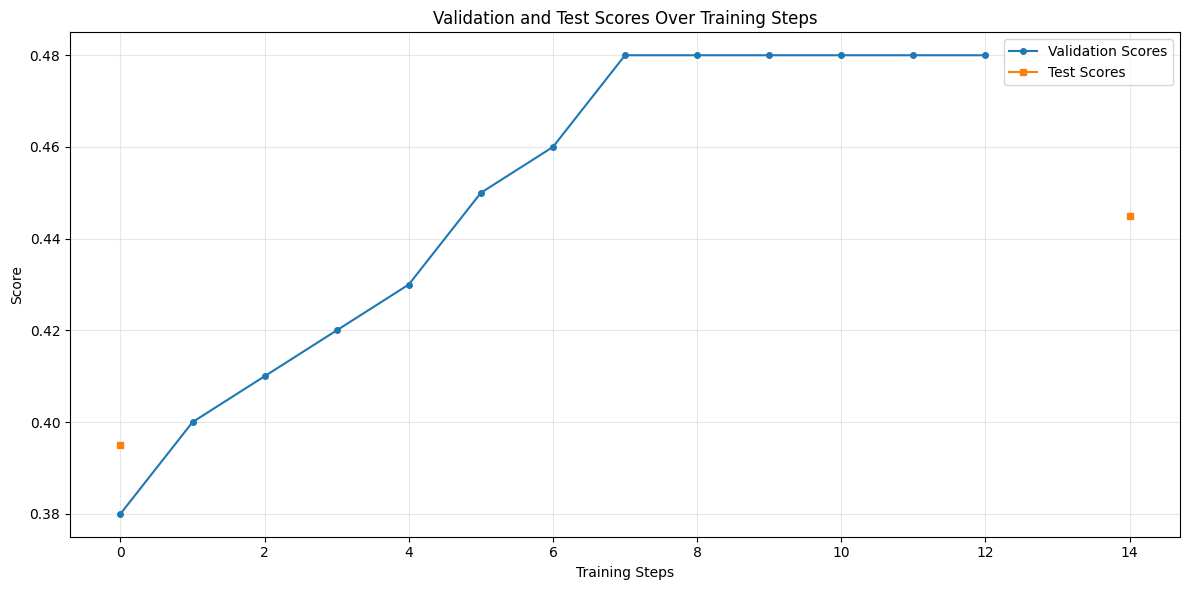

In [27]:
plot_training(file)

In [ ]:
# now use the opensource distill model
train(
    task_model_cliet=deepseek_r1_distilled_model["model_client"],
    task_model_kwargs=deepseek_r1_distilled_model["model_kwargs"],
    optimizer_model_config=gpt_o3_mini_model,
    backward_engine_model_config=gpt_o3_mini_model,
    max_steps=12,
)

Trainer(
  (adaltask): HotPotQAAdal(
    eval_fn: compute_single_item, backward_engine: None, backward_engine_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'o3-mini', 'temperature': 1}}, teacher_model_config: None, text_optimizer_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'o3-mini', 'temperature': 1}}
    (task): VanillaRAG(
      (retriever): DspyRetriever()
      (llm_parser): DataClassParser(
        data_class=AnswerData, format_type=json,            return_data_class=True, input_fields=[],            output_fields=['reasoning', 'answer']
        (_output_processor): JsonParser()
        (output_format_prompt): template: Your output should be formatted as a standard JSON instance with the following schema:
        ```
        {{schema}}
        ```
        -Make sure to always enclose the JSON output in triple backticks (```). Please do not add anything other than valid JSON output!
        -Use double quotes for the keys and


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 15552.32it/s]
Predicting: step(0): 0.4179 across 67 samples, Max potential: 0.61:  67%|██████▋   | 67/100 [01:29<01:02,  1.89s/it]Error at parsing output: Error: No JSON object or array found in the text: <think>
Okay, let me try to figure out the answer to this question. So, the user is asking about a key figure in the 2015 American documentary film directed by Malcolm Ingram. They want to know which university this person attended before being drafted 18th overall by the New Jersey Nets.

First, I need to identify which film they're talking about. The context mentions two films by Malcolm Ingram: "Out to Win" (2015) and "Continental" (2013). Since the question is about a 2015 film, it's definitely "Out to Win".

Looking at the key figures in "Out to Win", they include John Amaechi, Billy Bean, Jason Collins, Wade Davis, Brittney Griner, Billie Jean King, David Kopay, Conner Mertens, Martina Navratilova, and Michael Sam. Now, the q

Initial validation score: 0.39
Initial test score: 0.415
2025-02-04 17:01:53 - [trainer.py:2336:_fit_text_grad_constraint] - Fitting using Textual Gradient Descent with constraints
_fit_text_grad_constraint save to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_77514_run_1.json



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0


Training Step: 1:   0%|          | 0/25 [00:00<?, ?it/s]

Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': ' Kevin Daniels had a part in the 2004 American drama directed by whom?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'In which century was football introduced to this region represented by FC Espanya de Barcelona?'}, model_kwargs: {}

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1349.95it/s]



prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>




unwrapped_prompt_kwargs: {'context': None, 'question': 'The writer of Unbeaten Tracks in Japan founded what hospital in Srinagar?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': "Which album of Taylor Swift's the does the song appear that the optimistic lyrical message of Yodel It! has been compared to?"}, model_kwargs: {}

Training:   0%|          | 0/4 [00:00<?, ?it/s]



prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


2025-02-04 17:01:56 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:03<00:10,  3.53s/it]

2025-02-04 17:01:58 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 17:01:59 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  50%|█████     | 2/4 [00:05<00:05,  2.68s/it]

2025-02-04 17:01:59 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 6260.16it/s]


Moving batch eval: EvaluationResult(avg_score=0.3333333333333333, per_item_scores=[0.3333333333333333, 0, 1.0, 0], additional_info=None)
2025-02-04 17:01:59 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.3333333333333333
Moving batch correct size: 1
Moving batch error size: 3
Subset Error size: 2
Subset Correct size: 1
Subset score: 0.4444444444444444
2025-02-04 17:01:59 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.4444444444444444,0.4444444444444444
Subset loss backward...
2025-02-04 17:01:59 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 17:01:59 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 17:02:02 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: Isabella Hospital, gt: the John Bish



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 17:02:16 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:02:16 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:02:21 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1961.79it/s]
Predicting: step(1): 0.3846 across 3 samples, Max potential: 0.3846: 100%|██████████| 3/3 [00:09<00:00,  3.30s/it]


2025-02-04 17:02:31 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.3846153846153846 <= 0.4444444444444444




Proposing:  20%|██        | 1/5 [00:15<01:00, 15.23s/it]

Proposal: 2
2025-02-04 17:02:31 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:02:31 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:02:37 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1674.15it/s]
Predicting: step(1): 0.381 across 3 samples, Max potential: 0.381: 100%|██████████| 3/3 [00:10<00:00,  3.61s/it] 


2025-02-04 17:02:48 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.38095238095238093 <= 0.4444444444444444




Proposing:  40%|████      | 2/5 [00:31<00:47, 15.95s/it]

Proposal: 3
2025-02-04 17:02:48 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:02:48 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:02:53 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 43.39it/s]
Predicting: step(1): 0.4444 across 3 samples, Max potential: 0.4444: 100%|██████████| 3/3 [00:09<00:00,  3.20s/it]


2025-02-04 17:03:03 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.4444444444444444 <= 0.4444444444444444




Proposing:  60%|██████    | 3/5 [00:46<00:31, 15.66s/it]

Proposal: 4
2025-02-04 17:03:03 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:03:03 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:03:09 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1292.41it/s]
Predicting: step(1): 0.3846 across 3 samples, Max potential: 0.3846: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


2025-02-04 17:03:14 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.3846153846153846 <= 0.4444444444444444




Proposing:  80%|████████  | 4/5 [00:58<00:13, 13.98s/it]

Proposal: 5
2025-02-04 17:03:14 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:03:14 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:03:22 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1985.31it/s]
Predicting: step(1): 0.3846 across 3 samples, Max potential: 0.3846: 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]


2025-02-04 17:03:32 - [trainer.py:2223:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.3846153846153846 <= 0.4444444444444444




Proposing: 100%|██████████| 5/5 [01:16<00:00, 15.30s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to /Users/liyin/.adalflow/ckpt/HotPotQAAdal/constrained_max_steps_12_77514_run_1.json
Done with proposals


Training Step: 2:   4%|▍         | 1/25 [01:39<39:51, 99.66s/it]

Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

unwrapped_prompt_kwargs: {'context': None, 'question': 'Who defeated Sander Levin in the Michigan gubernatorial election, 1970? '}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What do Angela Carter and Josephine Tey have in common?'}, model_kwargs: {}

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 460.84it/s]



prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>
unwrapped_prompt_kwargs: {'context': None, 'question': 'Which one is older, the chairman of the Humphreys Company, or the American politician and medical doctor who beat him in the primary?'}, model_kwargs: {}unwrapped_prompt_kwargs: {'context': None, 'question': 'What is the name of the American artist who was part of a duo that mainly painted on the streets of downtown Manhattan?'}, model_kwargs: {}

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>




prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


Training:   0%|          | 0/4 [00:00<?, ?it/s]

prompt template: <START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
Context: {{context}}
Question: {{question}}
<END_OF_USER>


2025-02-04 17:03:37 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  25%|██▌       | 1/4 [00:04<00:14,  4.93s/it]

2025-02-04 17:03:38 - [generator.py:612:forward] - disable_backward_engine config: False
2025-02-04 17:03:41 - [generator.py:612:forward] - disable_backward_engine config: False


Training:  50%|█████     | 2/4 [00:08<00:08,  4.03s/it]

2025-02-04 17:03:49 - [generator.py:612:forward] - disable_backward_engine config: False


Training: 100%|██████████| 4/4 [00:16<00:00,  4.10s/it]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 3185.65it/s]


Moving batch eval: EvaluationResult(avg_score=0.26666666666666666, per_item_scores=[0.3333333333333333, 0, 1.0, 0, 0.8, 0, 0, 0], additional_info=None)
2025-02-04 17:03:49 - [trainer.py:2165:_text_grad_constraint_propose_step] - Moving batch acc: 0.26666666666666666
Moving batch correct size: 2
Moving batch error size: 6
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.45
2025-02-04 17:03:49 - [trainer.py:2171:_text_grad_constraint_propose_step] - Subset batch acc: 0.45,0.45
Subset loss backward...
2025-02-04 17:03:49 - [parameter.py:746:backward] - node: sum, component: sum, grad_fn: adalflow.optim.text_grad.ops.Sum.backward.
2025-02-04 17:03:49 - [parameter.py:746:backward] - node: EvalFnToTextLoss_output, component: EvalFnToTextLoss, grad_fn: adalflow.optim.text_grad.text_loss_with_eval_fn.EvalFnToTextLoss.backward.
2025-02-04 17:03:53 - [text_loss_with_eval_fn.py:321:_backward_through_one_predecessor] - pred: William Milliken, gt: Republican William Milliken
2025-02-04 1



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-02-04 17:04:11 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:04:11 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:04:16 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 458.76it/s]
Predicting: step(2): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]  


2025-02-04 17:04:21 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.45





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 21270.37it/s]
Predicting: step(2): 0.2892 across 83 samples, Max potential: 0.41:  83%|████████▎ | 83/100 [01:42<00:27,  1.63s/it]Error at parsing output: Error: No JSON object or array found in the text: <think>
Alright, I need to answer the question: "Carrie Coon plays Margo Dunne in a 2014 film set in what state?" 

First, I'll look through the provided context for information about Carrie Coon and the film she was in. 

In the context under "Carrie Coon," it mentions that she starred as Margo Dunne in the 2014 thriller film "Gone Girl." Then, in the "Gone Girl (film)" section, it states that the film is set in Missouri.

So, putting it together, Carrie Coon played Margo Dunne in "Gone Girl," which is set in Missouri. 

I should make sure my answer includes the state and cites the correct source from the context.
</think>

**Answer:** Carrie Coon plays Margo Dunne in the 2014 film "Gone Girl," which is set in the state of Misso

Optimizer revert: 0.27906976744186046 <= 0.39




Proposing:  20%|██        | 1/5 [02:15<09:03, 135.78s/it]

Proposal: 2
2025-02-04 17:06:27 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:06:27 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:06:32 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1181.33it/s]
Predicting: step(2): 0.7 across 4 samples, Max potential: 0.7: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]    


2025-02-04 17:06:39 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7 > 0.45





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 38286.66it/s]
Predicting: step(2): 0.4 across 10 samples, Max potential: 0.94:  10%|█         | 10/100 [00:14<02:11,  1.46s/it] Error at parsing JSON string: Got invalid JSON object with yaml.safe_load. Error: while parsing a flow mapping
  in "<unicode string>", line 1, column 1:
    {
    ^
expected ',' or '}', but got '<scalar>'
  in "<unicode string>", line 2, column 83:
     ... dentified as 'sometimes called "Eliza" or "Betsey"' in her conte ... 
                                         ^. Got JSON string: {
    "reasoning": "Elizabeth Schuyler Hamilton is identified as 'sometimes called "Eliza" or "Betsey"' in her context entry.",
    "answer": "Elizabeth Schuyler Hamilton"
}
Error at parsing output: Error: Got invalid JSON object with yaml.safe_load. Error: while parsing a flow mapping
  in "<unicode string>", line 1, column 1:
    {
    ^
expected ',' or '}', but got '<scalar>'
  in "<unicode string>", line 2, column 83:


Optimizer revert: 0.36082474226804123 <= 0.39




Proposing:  40%|████      | 2/5 [04:51<07:23, 147.73s/it]

Proposal: 3
2025-02-04 17:09:03 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:09:03 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:09:09 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 248.94it/s]
Predicting: step(2): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]  


2025-02-04 17:09:13 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.75 > 0.45





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 1350.98it/s]
Predicting: step(2): 0.2907 across 86 samples, Max potential: 0.39:  86%|████████▌ | 86/100 [01:56<00:18,  1.36s/it]


Optimizer revert: 0.28735632183908044 <= 0.39




Proposing:  60%|██████    | 3/5 [06:58<04:36, 138.20s/it]

Proposal: 4
2025-02-04 17:11:10 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:11:10 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:11:16 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1700.68it/s]
Predicting: step(2): 0.7 across 4 samples, Max potential: 0.7: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]    


2025-02-04 17:11:20 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7 > 0.45





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 15918.87it/s]
Predicting: step(2): 0.3511 across 94 samples, Max potential: 0.39:  94%|█████████▍| 94/100 [02:10<00:08,  1.38s/it]


Optimizer revert: 0.3473684210526316 <= 0.39




Proposing:  80%|████████  | 4/5 [09:19<02:19, 139.24s/it]

Proposal: 5
2025-02-04 17:13:31 - [tgd_optimizer.py:523:propose] - Proposing a new value.
2025-02-04 17:13:31 - [tgd_optimizer.py:456:_get_user_prompt_kwargs] - system_params: []
2025-02-04 17:13:36 - [tgd_optimizer.py:560:propose] - TGD LLM optimizer prompt: <START_OF_SYSTEM_PROMPT>
You are an excellent prompt engineer tasked with instruction and demonstration tuning a compound LLM system.
Your task is to refine a variable/prompt based on feedback from a batch of input data points.

The variable is either input or output of a functional component where the component schema will be provided.
If the same DataID has multiple gradients, it means this component/variable is called multiple times in the compound system(with a cycle) in the same order as it appears in the gradient list.

You Must edit the current variable with one of the following editing methods.
You can not rewrite everything all at once:

You have Four Editing Methods:
1. ADD new elements(instruction) to address each speci




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1416.40it/s]
Predicting: step(2): 0.7 across 4 samples, Max potential: 0.7: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]    


2025-02-04 17:13:41 - [trainer.py:2217:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7 > 0.45





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 42251.48it/s]
Predicting: step(2): 0.2857 across 7 samples, Max potential: 0.95:   6%|▌         | 6/100 [00:07<02:02,  1.30s/it]Error at parsing output: Error: No JSON object or array found in the text: <think>
Alright, so I need to figure out which eighth child and youngest son of Queen Victoria and Prince Albert that John Wickham Legg was recommended by Jenner to be the medical attendant for. 

Looking at the context, the relevant part is about John Wickham Legg. It says he was recommended by Jenner for the post of medical attendant to Prince Leopold, who was Queen Victoria's fourth son, later styled Duke of Albany. But wait, the question is asking for the eighth child and youngest son. 

Hmm, the context mentions that Prince Leopold was the fourth son. So maybe there's another child mentioned here that I'm missing. Let me check the other contexts. 

In the Frederick Twort context, it says he was born in 1877 and worked with Jen

In [ ]:
**Test dataset**

| Model | EM | Running Time | Notes |
| --- | --- | --- | --- |
| o1  | 49 | N/A |  |
| o3 mini | N/A |  | |
| gpt3.5 | 39.5 |  | |
| r1 distilled  | 41.5 |  | structure data format errors |
| gpt3.5 trained | 44.5 |  | |
| r1 distall trained |N/A|  | |

# 🤗  Your second section

# Issues and feedback

If you encounter any issues, please report them here: [GitHub Issues](https://github.com/SylphAI-Inc/LightRAG/issues).

For feedback, you can use either the [GitHub discussions](https://github.com/SylphAI-Inc/LightRAG/discussions) or [Discord](https://discord.gg/ezzszrRZvT).